## Ridge Regression w/ LASSO

### Environment Setup

In [2]:
versioninfo()

Julia Version 1.12.0
Commit b907bd0600 (2025-10-07 15:42 UTC)
Build Info:
  Official https://julialang.org release
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: 16 × 12th Gen Intel(R) Core(TM) i5-1240P
  WORD_SIZE: 64
  LLVM: libLLVM-18.1.7 (ORCJIT, alderlake)
  GC: Built with stock GC
Threads: 1 default, 1 interactive, 1 GC (on 16 virtual cores)


In [3]:

import Pkg
Pkg.activate(pwd())
Pkg.status()

  Activating project at `C:\Users\ALEKHYA\Downloads\Churn_prediction_project`


Status `C:\Users\ALEKHYA\Downloads\Churn_prediction_project\Project.toml`
  [336ed68f] CSV v0.10.15
⌅ [324d7699] CategoricalArrays v0.10.8
  [5ae59095] Colors v0.13.1
⌃ [a93c6f00] DataFrames v1.8.0
  [31c24e10] Distributions v0.25.122
  [da1fdf0e] FreqTables v1.0.0
  [38e38edf] GLM v1.9.0
⌃ [09f84164] HypothesisTests v0.11.5
⌃ [c709b415] Imbalance v0.1.6
  [5ab0869b] KernelDensity v0.6.10
  [add582a8] MLJ v0.21.0
⌃ [a7f614a8] MLJBase v1.9.2
⌃ [c6f25543] MLJDecisionTreeInterface v0.4.2
  [6ee0df7b] MLJLinearModels v0.10.1
⌃ [d491faf4] MLJModels v0.18.1
  [03970b2e] MLJTuning v0.8.8
  [54119dfa] MLJXGBoostInterface v0.3.13
  [636a865e] NearestNeighborModels v0.2.3
  [f0f68f2c] PlotlyJS v0.18.17
  [91a5bcdd] Plots v1.41.1
  [ce6b1742] RDatasets v0.7.7
  [8e980c4a] Shapefile v0.13.3
  [860ef19b] StableRNGs v1.0.3
  [10745b16] Statistics v1.11.1
⌃ [2913bbd2] StatsBase v0.34.6
  [f3b207a7] StatsPlots v0.15.8
  [009559a3] XGBoost v2.5.2
  [37e2e46d] LinearAlgebra v1.12.0
  [9a3f8284] Random v

In [4]:

# Color theme
primary_color = "#191919ff"
secondary_color = "#c67812ff"

"#c67812ff"

### Importing Libraries

In [5]:

# Data
using CSV, DataFrames, CategoricalArrays
# Statistics
using StableRNGs
# Visualization
using Plots
# ML Base
using MLJ, MLJModels, MLJBase, MLJTuning
# ML Linear
using MLJLinearModels
# ML Nearest Neighbors
using NearestNeighborModels
# ML Random Forest
using MLJDecisionTreeInterface

[ Info: Precompiling MLJ [add582a8-e3ab-11e8-2d5e-e98b27df1bc7] 

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up


### Loading Data

1. Standardized data, class balanced with SMOTE

In [7]:

# Load the the data csv file from the /data directory
telco_balanced_oversampling = DataFrame(CSV.File("telco_balanced_oversampling.csv"))

# Peek at the first 5 rows of the dataframe
first(telco_balanced_oversampling, 5) |> pretty

┌────────────┬────────────┬────────────────┬──────────────┬────────────────────┬─────────────────────┬─────────────┬──────────────┬────────────────┬─────────────────┬───────────────┬───────────────────┬────────────────────┬────────────────────┬──────────────────────────────────┬─────────────────────┬───────────────────────┬───────────────────────────────┬──────────────────────┬───────────────────────┬────────────────────────────────────────┬────────────────────────┬──────────────────┬───────────────────────────────────┬───────────────────┬──────────────────────────┬────────────────────┬────────────────────┬───────────────────────┬────────────────────────┬───────────────────────────────────────────┬─────────────────────────────────────────┬──────────────────────────────────┬──────────────────────────────┬─────────────────┬───────────────┬────────────┬─────────────┐
│ latitude   │ longitude  │ gender__Female │ gender__Male │ senior_citizen__No │ senior_citizen__Yes │ partner__No │ partne

### Splitting Data Helper Function

In [8]:
# Function that splits the data into training and testing sets, features and target
function split_data(df::DataFrame)

  # Use random seed for reproducibility
  rng = StableRNG(206)

  # Split the data into training and testing sets
  train, test = partition(df, 0.7, rng = rng, shuffle=true)


  # Split the training data into features and target
  X_train = train[!, Not(:churn_value)]
  y_train = coerce(train.churn_value, Multiclass)

  # Split the testing data into features and target
  X_test = test[!, Not(:churn_value)]
  y_test = coerce(test.churn_value, Multiclass)

  # Return all 4 subsets
  return X_train, y_train, X_test, y_test
end

split_data (generic function with 1 method)

### Defining Evaluation Metric Helper Function

In [9]:
# Define a function that takes in a model fit and returns the accuracy of the model
function metrics(model_name, predictions, y, threshold)

  # Make predictions
  p_hat = pdf.(predictions, 1)

  # Convert to binary
  y_hat = p_hat .> threshold

  TP = sum((y_hat .== 1) .& (y .== 1))
  TN = sum((y_hat .== 0) .& (y .== 0))
  FP = sum((y_hat .== 1) .& (y .== 0))
  FN = sum((y_hat .== 0) .& (y .== 1))

  accuracy = (TP + TN) / (TP + TN + FP + FN)
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  f1 = 2 * precision * recall / (precision + recall)
  area_under_curve = auc(predictions, y)

  # Create a DataFrame to store the metrics
  results = DataFrame(
    model = [model_name],
    accuracy = [round(accuracy, digits=3)],
    precision = [round(precision, digits=3)],
    recall = [round(recall, digits=3)],
    f1 = [round(f1, digits=3)],
    auc = [round(area_under_curve, digits=3)]
  )

  return results

end
     

metrics (generic function with 1 method)

### Metrics

In [10]:

# Define a function that takes model metrics and stores in a DataFrame
all_model_metrics = DataFrame(
  model = String[],
  accuracy = Float64[],
  precision = Float64[],
  recall = Float64[],
  f1 = Float64[],
  auc = Float64[]
)

Row,model,accuracy,precision,recall,f1,auc
,String,Float64,Float64,Float64,Float64,Float64


### Visualizing Regularization with Lasso

Tuning the Hyperparameter lambda helper function

In [11]:
function get_lasso_coefficients(df::DataFrame, lambda::Float64)

  # Split the data
  X_train, y_train, X_test, y_test = split_data(df)

  # Create the machine
  mach = machine(LogisticClassifier(penalty=:l1, lambda=lambda), X_train, y_train)

  fit!(mach, verbosity=0)

  # Evaluate test accuracy
  # Make predictions
  predictions = predict(mach, X_test)

  # Compute the metrics
  tuned_model_metrics = metrics(
    "Lasso Coefficients",
    predictions,
    y_test,
    0.5
  )

  coefs = fitted_params(mach).coefs

  # Convert vector of pairs to a DataFrame
  # Initialize an empty DataFrame
  df = DataFrame(
    lambda = [log(lambda)], 
    test_accuracy = [tuned_model_metrics.accuracy[1]]
  )

  # Iterate through the vector of pairs and populate the DataFrame
  for pair in coefs
      df[!, Symbol(pair.first)] = [pair.second]
  end

  return df
end

get_lasso_coefficients (generic function with 1 method)

### Fit the Model for a range of lambdas and record the resulting coefficients and test accuracy

In [12]:

lambdas = range(0.001, 0.2, length=200)

# Create an empty DataFrame to store the coefficients
coefs = DataFrame()

# Iterate through the lambdas and store the coefficients
for lambda in lambdas
  coefs = vcat(coefs, get_lasso_coefficients(telco_balanced_oversampling, lambda))
end

### Plotting the Coefficients by lambda

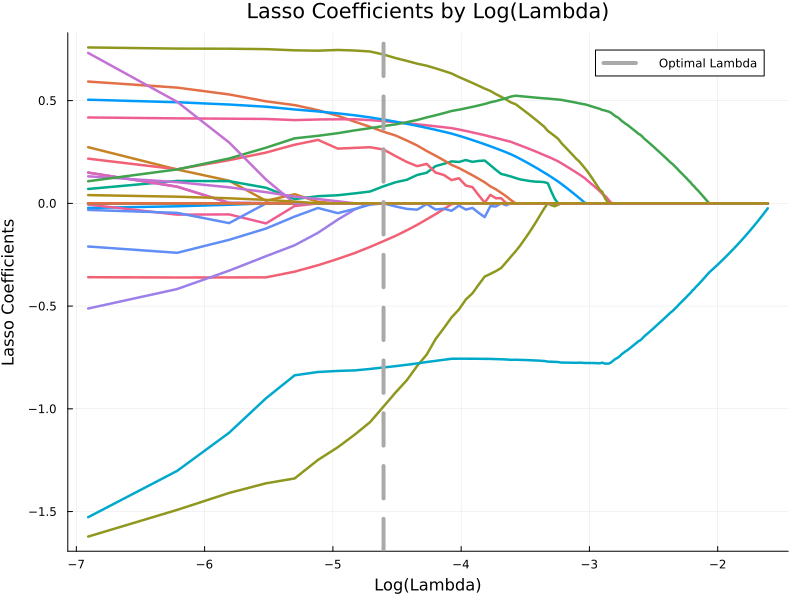

In [14]:

# Create an empty plot, no legend
coeff_plot = plot(xlabel="Log(Lambda)", ylabel="Lasso Coefficients", title="Lasso Coefficients by Log(Lambda)", legend=:topright, size=(800, 600))

# Add the columns one by one in a line plot
for i in 3:size(coefs, 2)
  coeff_plot = plot!(coefs[:, 1], coefs[:, i], linewidth=2.5, label=:none)
end

# Add a vertical line at the optimal lambda log(0.01)
vline!([log(0.01)], label="Optimal Lambda", color=:darkgrey, linewidth=4, linestyle=:dash)

# Show the plot
display(coeff_plot)


### Plot Test Accuracy by lambda

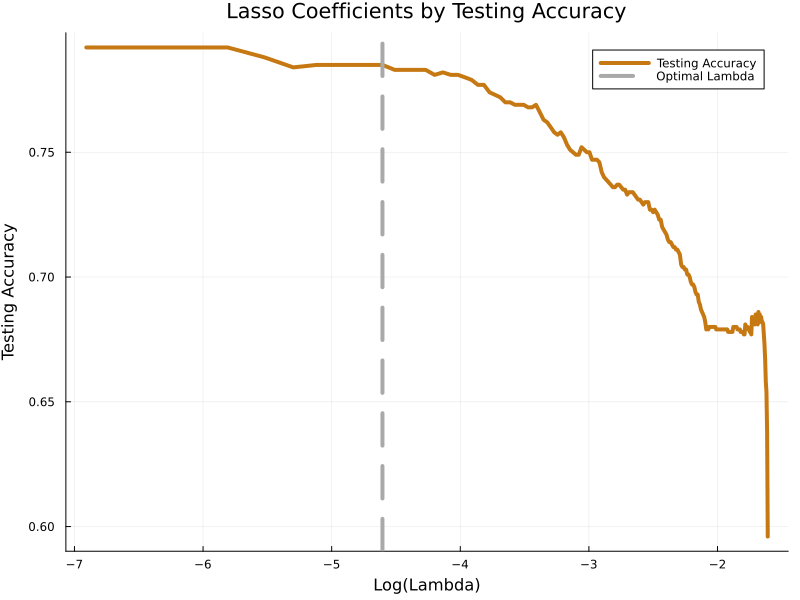

In [15]:

# Create an empty plot, no legend
test_accuracy_plot = plot(
  xlabel="Log(Lambda)",
  ylabel="Testing Accuracy",
  title="Lasso Coefficients by Testing Accuracy",
  legend=:topright,
  size=(800, 600)
)

# Add the testing accuracy line
test_accuracy_plot = plot!(coefs[:, 1], coefs[:, 2], linewidth=4, label="Testing Accuracy", color=secondary_color)

# Add a vertical line at the optimal lambda log(0.01)
vline!([log(0.01)], label="Optimal Lambda", color=:darkgrey, linewidth=4, linestyle=:dash)

# Show the plot
display(test_accuracy_plot)